In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os, os.path
import numpy as np
import pickle
from glob import glob
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

In [2]:
class ArgoverseDataset(Dataset):
    '''Dataset Class for Argoverse'''

    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, "*"))
        self.pkl_list.sort()

    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, index):
        pkl_path = self.pkl_list[index]

        with open(pkl_path, "rb") as p:
            data = pickle.load(p)

        if self.transform:
            data = self.transform(data)

        return data

In [3]:
train_dataset = ArgoverseDataset(data_path="data/new_train/")

In [ ]:
print("TOTAL TRAIN SAMPLES:", train_dataset.__len__())
print()
for key in train_dataset.__getitem__(0):
    '''
    city, lane, lane_norm, scene_idx, agent_id, car_mask
    *p_in*, *v_in*, *p_out*, *v_out*, track_id
    '''
    
    if key == "p_in":
        
        '''
        Min-Max Normalization to be in range [0, 1]
        
        x' = x - min(x) / max(x) - min(x)
        '''
        
        orig_arr = train_dataset.__getitem__(0)[key] # (60, 19, 2)
        orig_arr[orig_arr == 0] = np.nan
        
        p_0 = orig_arr[0][0]
        
        a_min, a_max = np.nanmin(orig_arr), np.nanmax(orig_arr)
        
        print("min:", a_min, "max:", a_max)
        
        minmax_arr = (orig_arr - a_min) / (a_max - a_min)
        
        p_0 = minmax_arr[0][0]
        
        minmax_zero = minmax_arr - p_0
        
        print(minmax_zero[:,18].shape)
        #print(minmax_arr[:60][:].shape)
        
        minmax_reshape = minmax_zero[:,1].reshape(-1, 2)
        
        #print(minmax_reshape.shape)
                
        #new = arr.reshape(-1, 2) # (60*19, 2) = (1140, 2)
        #print("p_in shape after:", new.shape)

In [4]:
def zeroNormNP(array, scale=1000, size=19, pos=np.array([-1, -1])):
    temp = []
    if np.array_equal(pos, np.array([-1, -1])):
        temp = array[:,0]
    else:
        temp = pos # should be N, 2
    temp = np.expand_dims(temp, 1)
    temp = np.repeat(temp, size, 1)
    
    return (array - temp) / scale, array[:,0]

(19, 60) (19, 60) (30, 60) (30, 60)


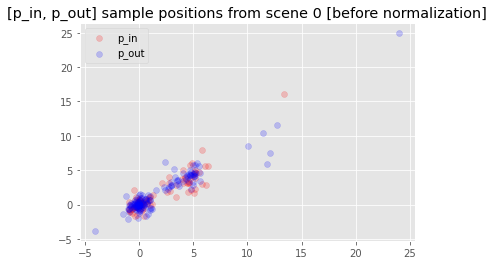

In [88]:
'''
before
'''
scene1_in = train_dataset.__getitem__(0)["v_in"]
scene1_out = train_dataset.__getitem__(0)["v_out"]

a, b = scene1_in.T
c, d = scene1_out.T

print(a.shape, b.shape, c.shape, d.shape)

plt.scatter(a, b, c="r", alpha=0.2)
plt.scatter(c, d, c="b", alpha=0.2)
plt.title("[p_in, p_out] sample positions from scene 0 [before normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

In [83]:
scene1_in.shape

(60, 19, 2)

ValueError: too many values to unpack (expected 3)

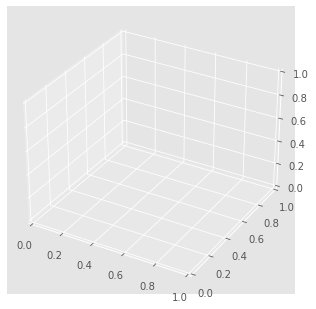

In [70]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

x_vals = 
y_vals = list(range(0, 100))
z_vals = list(range(0, 100))


ax.scatter(x_vals, y_vals, z_vals)
pyplot.show()

In [89]:
scene1_in = train_dataset.__getitem__(0)["v_in"]
scene1_out = train_dataset.__getitem__(0)["v_out"]

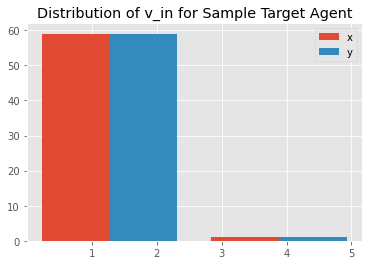

In [90]:
plt.hist(scene1_in[:,0].reshape(-1, 2), bins=2)
plt.title("Distribution of v_in for Sample Target Agent")
plt.legend(["x", "y"])
plt.show()

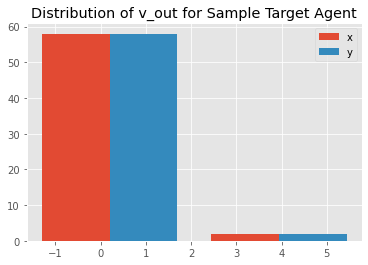

In [91]:
plt.hist(scene1_out[:,0].reshape(-1, 2), bins=2)
plt.title("Distribution of v_out for Sample Target Agent")
plt.legend(["x", "y"])
plt.show()

In [ ]:
plt.hist(scene1_out[:,0].reshape(-1, 2), bins=4)
plt.title("Distribution of p_out for Sample Target Agent")
plt.legend(["x", "y"])
plt.show()

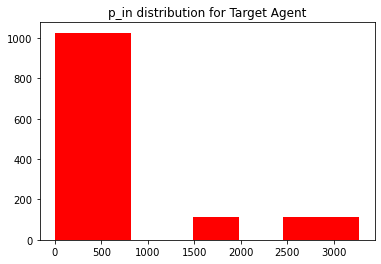

In [26]:
plt.hist(a.flatten(), bins=4, color="red")
plt.hist(b.flatten(), bins=4, color="red")
plt.title("p_in distribution for Target Agent")
#plt.hist(c.flatten(), bins=4, color="b")
#plt.hist(d.flatten(), bins=4, color="b")
plt.show()

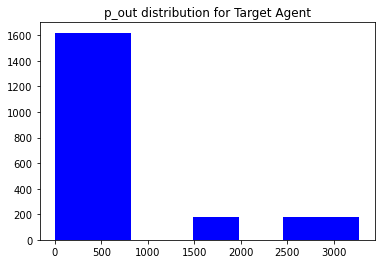

In [27]:
plt.title("p_out distribution for Target Agent")
plt.hist(c.flatten(), bins=4, color="b")
plt.hist(d.flatten(), bins=4, color="b")
plt.show()

In [ ]:
zero_scene1_in, p0_scene1_in = zeroNormNP(scene1_in, size=19)
zero_scene1_out, p0_scene1_out = zeroNormNP(scene1_out, size=30)

In [ ]:
'''
after
'''
a, b = zero_scene1_in.T
c, d = zero_scene1_out.T

plt.scatter(a, b, c="r", label=1, alpha=0.2)
plt.scatter(c, d, c="b", label=1, alpha=0.2)
plt.title("[p_in, p_out] sample positions from scene 0 [after normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

In [ ]:
flat_scene1_in = scene1_in.flatten()
flat_scene1_out = scene1_out.flatten()

plt.hist((flat_scene1_in, flat_scene1_out), color=["r", "b"], bins=5)
plt.title("Distribution of [p_in, p_out] values from scene 0 [before normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

In [ ]:
flat_scene1_in = zero_scene1_in.flatten()
flat_scene1_out = zero_scene1_out.flatten()

plt.hist((flat_scene1_in, flat_scene1_out), color=["r", "b"], bins=5)
plt.title("Distribution of [p_in, p_out] values from scene 0 [after normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

# Find Max Distance
Here, we want to find the largest path per car across all scenes

In [4]:
scenes = np.arange(train_dataset.__len__())

In [5]:
p_in = []

for i in tqdm(scenes, total=scenes.shape[0]):
    p_in.append(train_dataset.__getitem__(i)["p_in"])

100%|██████████| 205942/205942 [01:00<00:00, 3396.70it/s]


In [6]:
p_out = []

for i in tqdm(scenes, total=scenes.shape[0]):
    p_out.append(train_dataset.__getitem__(i)["p_out"])

100%|██████████| 205942/205942 [01:01<00:00, 3330.15it/s]


In [7]:
p_in = np.array(p_in)

In [8]:
p_out = np.array(p_out)

In [ ]:
#in_p0 = p_in[:,0:,0]

exp_in = np.expand_dims(p_in[:,0:,0], 2)
#exp_in = np.repeat(exp_in, 19, 2)

p_in = np.subtract(p_in, np.repeat(exp_in, 19, 2))


In [ ]:
out_p0 =  p_out[:,0:,0]

In [ ]:
exp_out = np.expand_dims(p_out[:,0:,0], 2)

In [ ]:
exp_out = np.repeat(exp_out, 30, 2)

In [ ]:
p_out = np.subtract(p_out, np.repeat(exp_out, 30, 2))

In [9]:
in_displacements = []

for i in range(60):
    max_val, min_val = np.amax(p_in[:,i]), np.amin(p_in[:,i])
    diff = max_val - min_val
    in_displacements.append(diff)
    print("Car" + str(i + 1) + ":", max_val, min_val, diff)
    print()

Car1: 4689.84423828125 9.119121551513672 4680.725116729736

Car2: 4735.943359375 -28.476301193237305 4764.419660568237

Car3: 4748.19482421875 -17.217008590698242 4765.411832809448

Car4: 4745.5712890625 -12.21413516998291 4757.785424232483

Car5: 4726.85107421875 -28.915882110595703 4755.766956329346

Car6: 4714.80029296875 -5.930739402770996 4720.731032371521

Car7: 4724.52880859375 -8.887921333312988 4733.416729927063

Car8: 4734.21923828125 -46.95796585083008 4781.17720413208

Car9: 4713.67724609375 -21.54179573059082 4735.219041824341

Car10: 4705.689453125 -29.827377319335938 4735.516830444336

Car11: 4728.41357421875 -6.055461406707764 4734.469035625458

Car12: 4703.7607421875 0.0 4703.7607421875

Car13: 4703.29345703125 -29.39227867126465 4732.685735702515

Car14: 4699.6005859375 0.0 4699.6005859375

Car15: 4686.720703125 0.0 4686.720703125

Car16: 4671.77099609375 -24.56757926940918 4696.338575363159

Car17: 4675.0791015625 0.0 4675.0791015625

Car18: 4684.20263671875 -1.46663

In [10]:
out_displacements = []

for i in range(60):
    max_val, min_val = np.amax(p_out[:,i]), np.amin(p_out[:,i])
    diff = max_val - min_val
    out_displacements.append(diff)
    print("Car" + str(i + 1) + ":", max_val, min_val, diff)
    print()

Car1: 4688.04345703125 24.899255752563477 4663.1442012786865

Car2: 4746.873046875 -60.59521484375 4807.46826171875

Car3: 4748.27978515625 -32.79796600341797 4781.077751159668

Car4: 4772.96142578125 -20.9713077545166 4793.932733535767

Car5: 4743.23046875 -38.31989669799805 4781.550365447998

Car6: 4727.34423828125 -23.62353515625 4750.9677734375

Car7: 4714.67333984375 -27.369237899780273 4742.04257774353

Car8: 4730.33203125 -53.91230392456055 4784.244335174561

Car9: 4729.67919921875 -5.357077598571777 4735.036276817322

Car10: 4728.3232421875 -32.68402862548828 4761.007270812988

Car11: 4769.42138671875 0.0 4769.42138671875

Car12: 4727.32373046875 -5.6892499923706055 4733.012980461121

Car13: 4702.84423828125 -29.346111297607422 4732.190349578857

Car14: 4724.5537109375 0.0 4724.5537109375

Car15: 4680.82080078125 0.0 4680.82080078125

Car16: 4666.6533203125 -24.62024688720703 4691.273567199707

Car17: 4660.5048828125 0.0 4660.5048828125

Car18: 4673.65234375 -1.4631174802780151

In [11]:
in_displacements = np.array(in_displacements)

In [12]:
out_displacements = np.array(out_displacements)

In [ ]:
plt.hist(in_displacements, color=["r"], bins=5)
plt.title("Distribution of p_in Displacements [before normalization]")
plt.legend(["p_in"])
plt.show()

In [ ]:
plt.hist(out_displacements, color=["b"], bins=5)
plt.title("Distribution of p_out Displacements [before normalization]")
plt.legend(["p_out"])
plt.show()

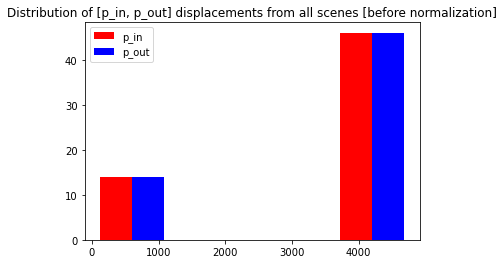

In [15]:
plt.hist((in_displacements, out_displacements), color=["r", "b"], bins=4)
plt.title("Distribution of [p_in, p_out] displacements from all scenes [before normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

In [ ]:
'''
after norm
'''

plt.hist((in_displacements, out_displacements), color=["r", "b"], bins=4)
plt.title("Distribution of [p_in, p_out] displacements from all scenes [after normalization]")
plt.legend(["p_in", "p_out"])
plt.show()

In [ ]:
p0_arr = distances[:,0:,0]
temp = np.expand_dims(p0_arr, 2)
temp = np.repeat(temp, 19, 2)
print(p0_arr.shape)
print(temp.shape)

norm_distances = distances - temp

print()

displacements = []

for i in range(60):
    max_val, min_val = np.amax(norm_distances[:,i]), np.amin(norm_distances[:,i])
    displacements.append(max_val - min_val)
    print("Car" + str(i + 1) + ":", max_val, min_val, (max_val - min_val))

displacements = np.array(displacements)
print(displacements.shape)
print()
print(displacements)
print()
print(np.amax(displacements), np.amin(displacements[:46]))

In [ ]:
# max p_in: 181.35986328125, min p_in: 0.117584228515625

norm_distances[:,0].shape

In [ ]:
x, y = orig.T
plt.scatter(x, y, c="b", label=1, alpha=0.2)
plt.show()

In [ ]:
x, y = norm.T
plt.scatter(x, y, c="b", label=1, alpha=0.2)
plt.show()

In [ ]:
x, y = minmax_reshape.T
plt.scatter(x, y, c="b", label=1, alpha=0.2)
plt.show()

In [ ]:
train_dataset = ArgoverseDataset(data_path="data/new_train/")
print("TOTAL TRAIN SAMPLES:", train_dataset.__len__())
print()
for key in train_dataset.__getitem__(0):
    '''
    city, lane, lane_norm, scene_idx, agent_id, car_mask
    *p_in*, *v_in*, *p_out*, *v_out*, track_id
    '''
    
    if key == "p_in":
        
        '''
        (0, 0) starting point
        '''
        
        orig_arr = train_dataset.__getitem__(5)[key] # (60, 19, 2)
        orig_arr[orig_arr == 0] = np.nan
        
        p_0 = orig_arr[0][0]
        
        print("p_0", p_0)
        
        zero_arr = orig_arr - p_0
        zero_reshape = zero_arr.reshape(-1, 2)
        
        #new = arr.reshape(-1, 2) # (60*19, 2) = (1140, 2)
        #print("p_in shape after:", new.shape)

        
#def norm_positions(p_arr, scale=1000):
#    for 

In [ ]:
x, y = zero_reshape.T
plt.scatter(x, y, c="b", label=1, alpha=0.3)
plt.show()

## Exploration

In [ ]:
print("TOTAL TRAIN SAMPLES:", train_dataset.__len__())
print("TOTAL VAL SAMPLES:", val_dataset.__len__())
print()
for key in train_dataset.__getitem__(0):
    '''
    city
    lane
    lane_norm
    scene_idx
    agent_id
    car_mask
    *p_in*
    *v_in*
    *p_out*
    *v_out*
    track_id
    '''
    
    all_keys = ["p_in", "v_in", "p_out", "v_out"]
    p_keys = ["p_in"]
    
    if key == "p_in":
        
        arr = train_dataset.__getitem__(0)[key] # (60, 19, 2)
        print("p_in shape before:", arr.shape)
        new = arr.reshape(-1, 2) # (60*19, 2) = (1140, 2)
        new[new==0] = np.nan
        print("p_in shape after:", new.shape)
    
    if key == "p_out":
        
        arr2 = train_dataset.__getitem__(0)[key] # (60, 19, 2)
        print("p_out shape before:", arr2.shape)
        new2 = arr.reshape(-1, 2) # (60*19, 2) = (1140, 2)
        new2[new2==0] = np.nan
        print("p_out shape after:", new2.shape)

In [ ]:
x, y = norm.T
plt.scatter(x, y, c="b", label=1, alpha=0.3)
plt.show()

In [ ]:
x, y = new.T
x2, y2 = new2.T


plt.scatter(x, y, c="b", label=1, alpha=0.3)
plt.scatter(x2, y2, c="r", marker="s", label="-1", alpha=0.2)
plt.show()

In [ ]:
new_x, new_y = np.linalg.norm(x), np.linalg.norm(y)
new_x2, new_y2 = np.linalg.norm(x2), np.linalg.norm(y2)

x3, y3 = x / new_x, y /new_y
x4, y4 = x2 / new_x2, y2 / new_y2

with nanx3[x3==0], y3[y3==0] = np.nan, np.nan
x4[x4==0], y4[y4==0] = np.nan, np.nan

In [ ]:
plt.scatter(x3, y3, c="b", label=1, alpha=0.3)
plt.scatter(x4, y4, c="r", marker="s", label="-1", alpha=0.2)
plt.show()

In [ ]:
(1, 19, 2) for one car
(5, 19, 2) for 5 cars

normalize based on axis

In [ ]:
z = np.arange(1, 10)
n = np.linalg.norm(z)
a = z / n

In [ ]:
a

In [ ]:
a * n